In [1]:
import create_sets
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import dlib
import os
%matplotlib inline

In [2]:
image = cv2.imread("./decompressed_dataset/a/jpg/i083qa-mn.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im = create_sets.crop_picture(image, 299)
labels = create_sets.load_csv()

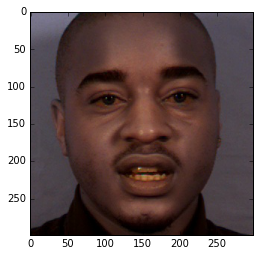

In [3]:
plt.imshow(im[0])

In [4]:
label = labels.loc[labels['name'] == "i083qa-mn"].values.tolist()[0][2:]
label_reloaded = create_sets.recalculate_landmarks(im[1],label)

for i in range(0,151,2):
    cv2.circle(im[0], (int(label_reloaded[i]),int(label_reloaded[i+1]) ), 2, (255, 0, 0), -1)

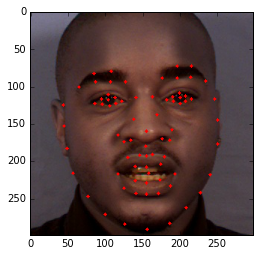

In [5]:
plt.imshow(im[0])

In [6]:
dataset = create_sets.gen_dataset(299)

generating the training and test set


  0% (0.05326231691078562 of 100) |       | Elapsed Time: 0:00:00 ETA:  0:05:38

[[[111 108 135]
  [109 106 133]
  [110 106 131]
  ..., 
  [105 100 122]
  [107 103 120]
  [111 107 122]]

 [[109 106 133]
  [108 105 132]
  [109 105 130]
  ..., 
  [109 104 126]
  [108 104 121]
  [107 103 118]]

 [[108 104 129]
  [109 105 130]
  [110 106 129]
  ..., 
  [110 105 125]
  [109 104 124]
  [105 101 118]]

 ..., 
 [[ 12   1   0]
  [ 12   1   0]
  [ 12   1   0]
  ..., 
  [ 12   0   0]
  [ 12   0   0]
  [ 12   0   0]]

 [[ 12   1   0]
  [ 12   1   0]
  [ 12   1   0]
  ..., 
  [ 11   0   0]
  [ 11   0   0]
  [ 11   0   0]]

 [[ 13   2   0]
  [ 12   1   0]
  [ 14   0   0]
  ..., 
  [ 11   0   0]
  [ 12   0   0]
  [ 11   0   0]]]
[[[121 117 140]
  [120 116 139]
  [124 121 142]
  ..., 
  [103 101 115]
  [100  98 112]
  [ 98  94 109]]

 [[123 119 142]
  [123 119 142]
  [124 121 142]
  ..., 
  [ 97  95 109]
  [ 97  93 108]
  [ 96  92 107]]

 [[125 121 144]
  [127 123 146]
  [126 123 144]
  ..., 
  [ 95  91 106]
  [ 96  92 107]
  [ 97  93 108]]

 ..., 
 [[ 15   4   0]
  [ 13   4   0]


  0% (0.10652463382157124 of 100) |       | Elapsed Time: 0:00:00 ETA:  0:08:32


[[[132 132 156]
  [127 127 151]
  [129 129 155]
  ..., 
  [147 153 187]
  [147 151 186]
  [146 150 187]]

 [[135 133 157]
  [129 129 153]
  [129 129 155]
  ..., 
  [146 152 186]
  [147 151 186]
  [146 150 187]]

 [[136 133 160]
  [133 133 159]
  [132 132 158]
  ..., 
  [145 149 186]
  [145 149 186]
  [145 149 186]]

 ..., 
 [[ 26  11   6]
  [ 25  12   6]
  [ 25  12   6]
  ..., 
  [ 20   9   5]
  [ 22   9   3]
  [ 22   7   2]]

 [[ 27  12   9]
  [ 25  12   6]
  [ 25  12   6]
  ..., 
  [ 27   9   5]
  [ 27   9   5]
  [ 26   8   4]]

 [[ 26  11   8]
  [ 24  11   5]
  [ 24  11   5]
  ..., 
  [ 28   7   2]
  [ 29   8   5]
  [ 29   9   8]]]
[[[109 108 124]
  [109 108 124]
  [109 108 124]
  ..., 
  [104 101 118]
  [106 103 120]
  [108 104 121]]

 [[109 106 123]
  [108 107 123]
  [109 108 124]
  ..., 
  [105 102 119]
  [105 102 119]
  [107 103 120]]

 [[107 104 121]
  [108 105 122]
  [109 106 123]
  ..., 
  [107 104 121]
  [108 104 121]
  [107 103 120]]

 ..., 
 [[ 91  71  60]
  [ 89  73  83]

  0% (0.15978695073235685 of 100) |       | Elapsed Time: 0:00:00 ETA:  0:09:38


[[[116 113 132]
  [113 110 127]
  [111 109 123]
  ..., 
  [ 90  85  92]
  [ 90  85  92]
  [ 91  86  93]]

 [[113 110 129]
  [112 109 126]
  [111 109 123]
  ..., 
  [ 89  84  91]
  [ 89  84  91]
  [ 90  85  92]]

 [[111 108 127]
  [110 107 124]
  [109 107 121]
  ..., 
  [ 88  83  90]
  [ 89  84  91]
  [ 88  83  90]]

 ..., 
 [[ 83  79  93]
  [ 80  76  93]
  [ 79  75  90]
  ..., 
  [ 36  32  33]
  [ 36  34  37]
  [ 43  39  40]]

 [[ 82  78  92]
  [ 79  75  92]
  [ 78  74  89]
  ..., 
  [ 56  51  58]
  [ 52  50  51]
  [ 42  42  40]]

 [[ 80  76  90]
  [ 78  74  91]
  [ 78  74  89]
  ..., 
  [ 62  50  52]
  [ 62  53  48]
  [ 54  49  43]]]
[[[156 161 201]
  [157 162 202]
  [159 163 201]
  ..., 
  [154 159 199]
  [155 160 200]
  [156 159 200]]

 [[156 161 201]
  [157 160 201]
  [158 162 200]
  ..., 
  [158 163 203]
  [158 163 203]
  [158 161 202]]

 [[157 160 201]
  [157 161 199]
  [158 162 200]
  ..., 
  [160 165 205]
  [159 162 203]
  [156 159 200]]

 ..., 
 [[103  90  99]
  [114 100 113]

  0% (0.18641810918774965 of 100) |       | Elapsed Time: 0:00:01 ETA:  0:10:12


[[[129 127 151]
  [128 126 148]
  [130 128 150]
  ..., 
  [ 98  94 108]
  [ 98  94 108]
  [ 99  93 107]]

 [[127 124 151]
  [129 127 149]
  [131 129 151]
  ..., 
  [ 96  92 106]
  [ 95  91 105]
  [ 95  92 103]]

 [[131 128 157]
  [130 128 149]
  [129 127 148]
  ..., 
  [ 96  92 106]
  [ 94  90 104]
  [ 93  90 101]]

 ..., 
 [[ 84  77  85]
  [ 83  76  84]
  [ 84  78  88]
  ..., 
  [135 105 105]
  [135 105 107]
  [135 105 107]]

 [[ 85  78  86]
  [ 84  76  87]
  [ 84  78  88]
  ..., 
  [136 106 106]
  [136 106 108]
  [136 106 108]]

 [[ 88  80  91]
  [ 86  80  90]
  [ 86  80  90]
  ..., 
  [140 110 112]
  [139 109 111]
  [138 108 110]]]
[[[112 109 130]
  [112 109 130]
  [111 107 130]
  ..., 
  [106  99 115]
  [108 102 116]
  [109 103 117]]

 [[112 109 130]
  [113 110 131]
  [114 110 133]
  ..., 
  [106 102 117]
  [105 101 116]
  [105 101 115]]

 [[112 109 130]
  [114 111 132]
  [115 111 134]
  ..., 
  [108 104 119]
  [106 102 117]
  [105 101 116]]

 ..., 
 [[ 74  67  74]
  [ 74  67  75]

  0% (0.21304926764314247 of 100) |       | Elapsed Time: 0:00:01 ETA:  0:10:31


[[[ 82  79  86]
  [ 83  80  87]
  [ 83  80  87]
  ..., 
  [107 104 115]
  [106 102 116]
  [109 103 117]]

 [[ 82  79  86]
  [ 82  79  86]
  [ 82  79  86]
  ..., 
  [109 103 117]
  [106  99 115]
  [106  99 115]]

 [[ 84  81  88]
  [ 83  80  87]
  [ 82  79  86]
  ..., 
  [109 102 118]
  [105  98 114]
  [104  97 115]]

 ..., 
 [[ 82  76  90]
  [ 82  76  90]
  [ 83  77  89]
  ..., 
  [143 116 121]
  [141 112 117]
  [139 110 114]]

 [[ 82  76  90]
  [ 82  76  90]
  [ 83  77  89]
  ..., 
  [149 122 127]
  [144 117 122]
  [142 113 118]]

 [[ 83  77  91]
  [ 82  76  90]
  [ 81  75  87]
  ..., 
  [152 127 133]
  [146 119 124]
  [140 113 118]]]
[[[162 157 198]
  [161 159 199]
  [160 159 201]
  ..., 
  [156 162 196]
  [156 161 193]
  [157 160 193]]

 [[162 160 200]
  [160 158 198]
  [160 159 201]
  ..., 
  [156 162 196]
  [155 160 192]
  [156 159 192]]

 [[162 160 200]
  [161 159 199]
  [161 160 200]
  ..., 
  [158 162 199]
  [156 160 195]
  [156 159 194]]

 ..., 
 [[ 89  83  97]
  [ 92  84  99]

  0% (0.2929427430093209 of 100) |        | Elapsed Time: 0:00:01 ETA:  0:12:02


[[[109 105 130]
  [110 106 131]
  [110 106 131]
  ..., 
  [106 102 117]
  [107 103 118]
  [109 105 120]]

 [[109 105 132]
  [110 106 131]
  [109 105 130]
  ..., 
  [108 104 121]
  [108 104 121]
  [108 104 121]]

 [[110 106 133]
  [110 106 133]
  [109 105 130]
  ..., 
  [110 105 125]
  [110 105 125]
  [108 103 123]]

 ..., 
 [[209 164 145]
  [206 163 146]
  [207 166 148]
  ..., 
  [204 164 139]
  [205 163 138]
  [205 161 132]]

 [[210 165 142]
  [206 163 146]
  [206 164 152]
  ..., 
  [202 165 138]
  [209 163 140]
  [215 158 141]]

 [[208 164 139]
  [206 163 146]
  [207 164 155]
  ..., 
  [197 160 131]
  [207 156 137]
  [216 149 143]]]
[[[ 80  72  83]
  [ 81  73  84]
  [ 82  74  85]
  ..., 
  [ 83  73  82]
  [ 82  72  81]
  [ 82  72  81]]

 [[ 81  73  84]
  [ 82  74  85]
  [ 83  75  86]
  ..., 
  [ 83  73  84]
  [ 83  73  84]
  [ 80  73  81]]

 [[ 81  73  84]
  [ 83  75  86]
  [ 85  77  88]
  ..., 
  [ 82  72  83]
  [ 81  73  84]
  [ 80  73  81]]

 ..., 
 [[163 159 134]
  [125 124 104]

  0% (0.34620505992010653 of 100) |       | Elapsed Time: 0:00:02 ETA:  0:11:56


[[[ 96  94 107]
  [ 97  93 108]
  [ 97  93 110]
  ..., 
  [147 148 176]
  [147 148 176]
  [144 148 175]]

 [[ 95  93 104]
  [ 95  93 107]
  [ 97  93 110]
  ..., 
  [148 149 177]
  [145 149 176]
  [143 147 174]]

 [[ 96  94 105]
  [ 96  94 107]
  [ 98  94 109]
  ..., 
  [148 149 177]
  [145 149 176]
  [144 148 175]]

 ..., 
 [[147 153 127]
  [151 159 118]
  [174 185 129]
  ..., 
  [  6   0   0]
  [  4   0   0]
  [ 11  10   6]]

 [[152 153 122]
  [170 185 144]
  [210 216 180]
  ..., 
  [  4   0   0]
  [  4   1   0]
  [ 14  11   6]]

 [[187 178 149]
  [199 203 176]
  [219 225 213]
  ..., 
  [  8   3   0]
  [  5   2   0]
  [ 10   7   2]]]
[[[111 106 126]
  [109 104 127]
  [110 104 130]
  ..., 
  [107 103 120]
  [107 102 122]
  [110 105 125]]

 [[110 105 127]
  [111 106 129]
  [112 106 134]
  ..., 
  [108 104 121]
  [108 103 123]
  [109 104 124]]

 [[110 105 127]
  [112 107 130]
  [114 108 136]
  ..., 
  [109 104 124]
  [108 103 123]
  [106 101 123]]

 ..., 
 [[194 188 156]
  [195 189 155]

  0% (0.3994673768308921 of 100) |        | Elapsed Time: 0:00:02 ETA:  0:11:49


[[[ 26  18  16]
  [ 29  20  21]
  [ 34  25  28]
  ..., 
  [ 97  96 102]
  [ 92  90 101]
  [ 92  88 102]]

 [[ 27  18  21]
  [ 31  22  25]
  [ 36  27  32]
  ..., 
  [ 94  93 101]
  [ 96  94 107]
  [ 93  89 104]]

 [[ 30  19  23]
  [ 36  25  31]
  [ 40  29  35]
  ..., 
  [ 94  94 104]
  [ 93  91 105]
  [ 92  89 106]]

 ..., 
 [[169 240 208]
  [171 236 206]
  [176 236 208]
  ..., 
  [199 178 157]
  [198 179 149]
  [196 176 141]]

 [[170 243 213]
  [173 238 208]
  [177 237 209]
  ..., 
  [196 178 154]
  [200 181 151]
  [199 180 147]]

 [[176 243 212]
  [171 242 210]
  [163 242 211]
  ..., 
  [192 187 155]
  [198 187 157]
  [201 184 156]]]
[[[163 161 208]
  [159 160 206]
  [159 160 204]
  ..., 
  [156 160 205]
  [158 163 203]
  [160 166 202]]

 [[160 158 205]
  [160 158 205]
  [160 161 205]
  ..., 
  [156 160 205]
  [157 162 202]
  [158 163 201]]

 [[160 159 203]
  [161 160 204]
  [161 162 206]
  ..., 
  [158 162 207]
  [158 163 203]
  [159 163 201]]

 ..., 
 [[199 220 211]
  [208 236 222]

  0% (0.45272969374167776 of 100) |       | Elapsed Time: 0:00:02 ETA:  0:11:25


[[[122 119 140]
  [123 120 139]
  [124 121 138]
  ..., 
  [ 89  78  92]
  [ 85  79  89]
  [ 82  76  86]]

 [[125 122 143]
  [124 121 140]
  [124 121 138]
  ..., 
  [ 87  76  92]
  [ 84  78  88]
  [ 83  77  87]]

 [[124 121 142]
  [125 122 141]
  [123 120 137]
  ..., 
  [ 86  75  91]
  [ 82  76  86]
  [ 83  77  87]]

 ..., 
 [[169  95  86]
  [166  92  83]
  [167  94  85]
  ..., 
  [129  59  47]
  [128  60  57]
  [130  61  56]]

 [[173  96  88]
  [170  96  87]
  [170  96  87]
  ..., 
  [132  64  51]
  [130  61  56]
  [132  63  58]]

 [[178 100  90]
  [176  99  89]
  [173  96  86]
  ..., 
  [130  62  49]
  [130  61  56]
  [132  63  56]]]
[[[115 108 124]
  [115 108 124]
  [116 109 127]
  ..., 
  [107 100 118]
  [107 100 118]
  [107 100 118]]

 [[114 107 125]
  [114 107 125]
  [116 109 127]
  ..., 
  [107 100 118]
  [106  99 117]
  [105  98 116]]

 [[113 106 124]
  [114 106 127]
  [115 107 128]
  ..., 
  [108 100 121]
  [106  99 117]
  [104  97 115]]

 ..., 
 [[192  90  75]
  [189  87  72]

  0% (0.5059920106524634 of 100) |        | Elapsed Time: 0:00:03 ETA:  0:11:16


[[[147 152 184]
  [145 149 184]
  [148 151 186]
  ..., 
  [150 153 184]
  [149 149 187]
  [150 150 188]]

 [[151 156 188]
  [147 150 185]
  [148 150 188]
  ..., 
  [149 152 183]
  [149 147 186]
  [149 147 186]]

 [[150 155 187]
  [149 152 187]
  [149 151 189]
  ..., 
  [146 149 180]
  [152 147 187]
  [150 145 185]]

 ..., 
 [[216 148 147]
  [216 148 147]
  [215 147 144]
  ..., 
  [170 103  95]
  [180 111 104]
  [187 118 111]]

 [[215 147 146]
  [219 151 150]
  [214 149 147]
  ..., 
  [178 111 103]
  [183 115 106]
  [190 122 113]]

 [[214 146 147]
  [220 154 155]
  [215 151 149]
  ..., 
  [189 120 113]
  [193 125 114]
  [198 130 119]]]
[[[109 108 126]
  [110 109 127]
  [112 109 128]
  ..., 
  [108 103 126]
  [110 102 126]
  [111 102 129]]

 [[109 108 126]
  [110 109 127]
  [111 108 127]
  ..., 
  [108 103 125]
  [110 102 126]
  [111 103 127]]

 [[109 108 126]
  [110 107 126]
  [110 107 126]
  ..., 
  [110 102 125]
  [110 102 125]
  [110 102 125]]

 ..., 
 [[166 119 113]
  [156 109 103]

  0% (0.559254327563249 of 100) |         | Elapsed Time: 0:00:03 ETA:  0:11:19


[[[ 90  83  99]
  [ 88  82  94]
  [ 90  85  92]
  ..., 
  [ 88  80  91]
  [ 88  80  93]
  [ 89  81  94]]

 [[ 89  83  97]
  [ 89  83  93]
  [ 90  85  92]
  ..., 
  [ 89  81  92]
  [ 87  79  92]
  [ 89  81  94]]

 [[ 90  84  94]
  [ 89  83  93]
  [ 90  85  92]
  ..., 
  [ 87  81  91]
  [ 87  81  93]
  [ 88  82  94]]

 ..., 
 [[ 92  86 100]
  [ 91  85  99]
  [ 91  85  99]
  ..., 
  [ 90  80  91]
  [ 87  80  88]
  [ 89  82  90]]

 [[ 91  84 102]
  [ 90  83 101]
  [ 91  84 100]
  ..., 
  [ 88  80  91]
  [ 86  78  89]
  [ 87  79  90]]

 [[ 92  85 103]
  [ 92  85 103]
  [ 90  86 101]
  ..., 
  [ 85  79  91]
  [ 85  77  90]
  [ 84  76  89]]]
[[[156 159 204]
  [158 161 206]
  [158 161 206]
  ..., 
  [154 158 205]
  [155 160 202]
  [157 162 202]]

 [[157 160 205]
  [158 161 206]
  [158 161 206]
  ..., 
  [161 165 212]
  [159 164 206]
  [154 159 199]]

 [[159 162 207]
  [159 162 205]
  [159 162 205]
  ..., 
  [159 163 210]
  [158 163 205]
  [154 159 199]]

 ..., 
 [[194 188 200]
  [195 189 201]

  0% (0.6125166444740346 of 100) |        | Elapsed Time: 0:00:04 ETA:  0:11:20


[[[ 83  72  88]
  [ 79  68  85]
  [ 78  70  85]
  ..., 
  [ 86  78  91]
  [ 84  78  88]
  [ 83  77  87]]

 [[ 82  71  87]
  [ 78  67  84]
  [ 80  69  83]
  ..., 
  [ 85  77  90]
  [ 84  78  90]
  [ 83  77  87]]

 [[ 84  73  89]
  [ 82  71  88]
  [ 81  70  84]
  ..., 
  [ 84  76  89]
  [ 84  78  90]
  [ 83  77  89]]

 ..., 
 [[ 62  56  60]
  [ 61  52  53]
  [ 56  48  45]
  ..., 
  [117  88  92]
  [118  89  93]
  [118  89  91]]

 [[ 54  43  47]
  [ 52  38  38]
  [ 58  44  41]
  ..., 
  [120  91  93]
  [121  92  94]
  [121  92  94]]

 [[ 66  47  51]
  [ 62  42  41]
  [ 77  57  56]
  ..., 
  [122  92  94]
  [124  94  96]
  [122  93  97]]]
[[[112 109 128]
  [113 109 134]
  [114 109 139]
  ..., 
  [108 101 119]
  [106 102 116]
  [106 103 112]]

 [[113 109 132]
  [114 110 135]
  [115 111 138]
  ..., 
  [108 101 119]
  [105 101 116]
  [105 102 113]]

 [[116 112 139]
  [117 113 138]
  [119 115 138]
  ..., 
  [106 102 119]
  [105 101 116]
  [104 100 115]]

 ..., 
 [[140 108 113]
  [139 106 113]

KeyboardInterrupt: 

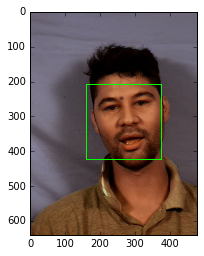